# **P1: Probabilistic Latent Semantic Indexing (PLSI) for Speech Denoising**

In [76]:
import librosa
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

In [77]:
# Load the trs audio file from the google drive. Later load trn and xnf files too...
trs_audio = "/content/drive/MyDrive/Colab drive/trs.wav"
trn_audio = "/content/drive/MyDrive/Colab drive/trn.wav"

trs_signal, sampling_rate = librosa.load(trs_audio, sr=None, dtype=np.float32)
print("Shape of trs audio signal:", trs_signal.shape)

Shape of trs audio signal: (403255,)


In [78]:
trn_signal, sampling_rate = librosa.load(trn_audio, sr=None, dtype=np.float32)
print("Shape of trn audio signal:", trn_signal.shape)

Shape of trn audio signal: (403255,)


In [79]:
tes_audio = "/content/drive/MyDrive/Colab drive/tes.wav"
tes_signal, sampling_rate = librosa.load(tes_audio, sr=None, dtype=np.float32)
print("Shape of tes audio signal:", tes_signal.shape)

Shape of tes audio signal: (50791,)


In [87]:
def stft_matrix(N):
    stft_matrix = []
    for n in range(N):
        row = []
        for f in range(N):
            element = np.exp(-1j * (2 * np.pi * f * n / N))
            row.append(element)
        stft_matrix.append(row)
    return np.array(stft_matrix)

def apply_stft(audio, N, hop_size):
    stft_mat = stft_matrix(N)
    hann_window = np.hanning(N)

    stft_frames = []

    for i in range(0, len(audio) - N + 1, hop_size):
        frame = audio[i:i+N] * hann_window
        stft_frame = np.dot(stft_mat, frame)
        stft_frames.append(stft_frame)

    return np.array(stft_frames)

In [81]:
# Define the STFT parameters (same as in Homework #3 P2)
N = 1024  # FFT size
hop_size = 512  # Hop size

# Apply STFT to trs.wav and trn.wav
trs_stft = apply_stft(trs_signal, N, hop_size)
trn_stft = apply_stft(trn_signal, N, hop_size)


In [82]:
trs_stft.shape, trn_stft.shape

((786, 1024), (786, 1024))

In [88]:
# Step 6: Train a PLSI model for speech denoising
K = 5  # Number of latent variables
num_frames_trs = trs_stft.shape[0]

# Initialize B and Θ matrices randomly with complex values
B = np.random.rand(N, K) + 1j * np.random.rand(N, K)
B /= np.sum(B, axis=0)

Theta = np.random.rand(K, num_frames_trs) + 1j * np.random.rand(K, num_frames_trs)
Theta /= np.sum(Theta, axis=0)

# EM algorithm for PLSI
num_iterations = 50
for _ in range(num_iterations):
    # E-step: Update Theta
    for t in range(num_frames_trs):
        p_k_given_t = np.dot(B.T, trs_stft[t])
        p_k_given_t /= np.sum(p_k_given_t)
        Theta[:, t] = p_k_given_t

    # M-step: Update B
    for k in range(K):
        for t in range(num_frames_trs):
            B[:, k] += trs_stft[t] * Theta[k, t]
        B[:, k] /= np.sum(B[:, k])


In [84]:
# Step 7: Reconstruct cleaned-up speech signal using inverse-STFT
def apply_inverse_stft(stft_frames, N, hop_size):
    # Initialize inverse STFT matrix
    istft_mat = np.conjugate(stft_matrix(N))
    time_signal = np.zeros((stft_frames.shape[0] - 1) * hop_size + N, dtype=np.complex128)

    # Apply inverse STFT to each frame
    for i in range(stft_frames.shape[0]):
        frame = np.dot(istft_mat, stft_frames[i])
        start_index = i * hop_size
        time_signal[start_index:start_index + N] += frame

    return time_signal

# Reconstruct cleaned-up speech signal for trs.wav
trs_reconstructed = apply_inverse_stft(np.dot(Theta.T, B.T), N, hop_size)


In [85]:
trs_reconstructed.shape, tes_signal.shape

((402944,), (50791,))

In [ ]:
snr = 10 * np.log10(np.dot(tes_signal.T, tes_signal) / np.dot((tes_signal - trs_reconstructed).T, (tes_signal - trs_reconstructed)))
print('The SNR value is: ' + str(np.round(snr, 3)))

# **P2: Optimal K for PLSI**

In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
file_path = '/content/drive/MyDrive/Colab drive/faces.npy'

faces = np.load(file_path)

In [31]:
faces.shape

(441, 8)

In [66]:
def plsi_declare(input_data, num_topics):
    num_documents, num_words = input_data.shape
    document_topic_matrix = np.random.dirichlet(np.ones(num_topics), size=num_documents)
    topic_word_matrix = np.random.dirichlet(np.ones(num_words), size=num_topics)
    return document_topic_matrix, topic_word_matrix

In [67]:
def e_step(input_data, document_topic_matrix, topic_word_matrix):
    num_documents, num_words = input_data.shape
    num_topics = document_topic_matrix.shape[1]
    probabilities = np.zeros((num_documents, num_words, num_topics))
    epsilon = 1e-10

    for i in range(num_documents):
        denominator = document_topic_matrix[i, :] @ topic_word_matrix + epsilon
        for k in range(num_topics):
            probabilities[i, :, k] = document_topic_matrix[i, k] * topic_word_matrix[k, :] / denominator

    return probabilities

In [68]:
def m_step(input_data, probabilities):
    num_documents, num_words, num_topics = probabilities.shape
    document_topic_matrix = np.zeros((num_documents, num_topics))
    topic_word_matrix = np.zeros((num_topics, num_words))

    for k in range(num_topics):
        topic_word_matrix[k, :] = np.sum(input_data * probabilities[:, :, k], axis=0)
        topic_word_matrix[k, :] /= np.sum(topic_word_matrix[k, :]) + 1e-10
        for i in range(num_documents):
            document_topic_matrix[i, k] = np.sum(input_data[i, :] * probabilities[i, :, k])
        document_topic_matrix[:, k] /= np.sum(document_topic_matrix[:, k]) + 1e-10

    return document_topic_matrix, topic_word_matrix

In [69]:
def plsi(input_data, num_topics, num_iterations=100):
    document_topic_matrix, topic_word_matrix = initialize_plsi(input_data, num_topics)
    for _ in range(num_iterations):
        probabilities = e_step(input_data, document_topic_matrix, topic_word_matrix)
        document_topic_matrix, topic_word_matrix = m_step(input_data, probabilities)
    return document_topic_matrix, topic_word_matrix

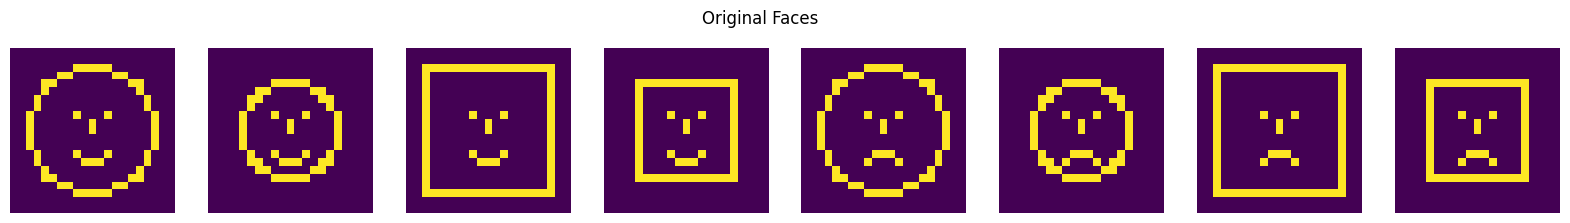

In [70]:
# Plotting the original faces
fig, axes = plt.subplots(1, 8, figsize=(20, 2.5))
for i, ax in enumerate(axes):
    ax.imshow(faces[i].reshape(21, 21), cmap='viridis')
    ax.axis('off')
plt.suptitle('Original Faces')
plt.show()

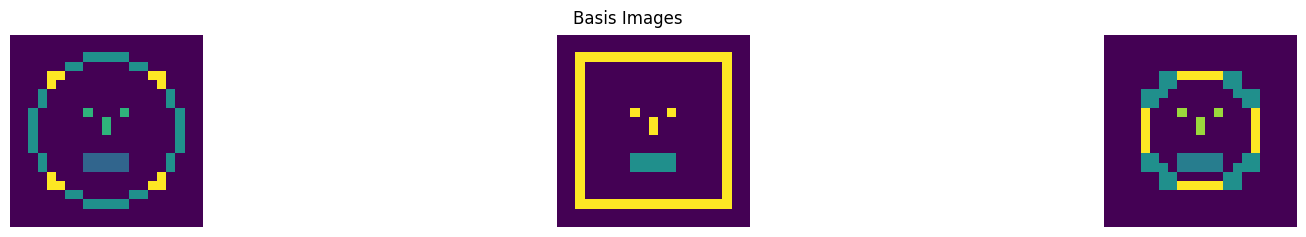

In [71]:
# PLSI
K = 3  # Number of topics (latent variables)
Theta, B = plsi(faces, K)

# Plot the basis images (topics)
fig, axes = plt.subplots(1, K, figsize=(20, 2.5))
for i, ax in enumerate(axes):
    ax.imshow(B[i].reshape(21, 21), cmap='viridis')
    ax.axis('off')
plt.suptitle('Basis Images')
plt.show()

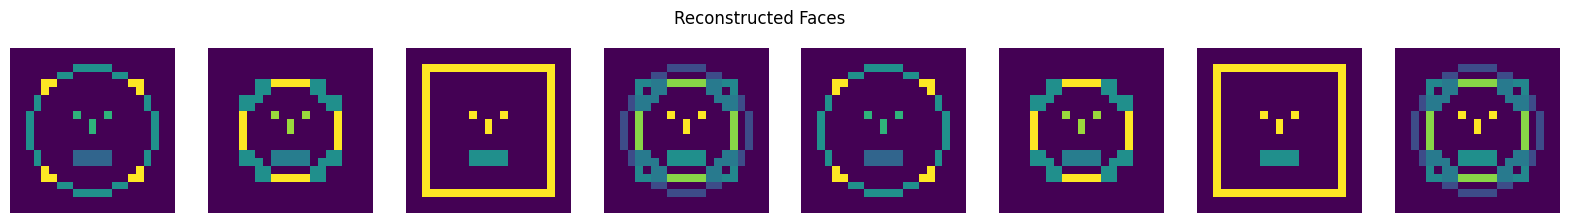

In [73]:
# Reconstruct the faces using the weights and basis images
reconstructed_faces = np.dot(Theta, B)

# Plot the reconstructed faces
fig, axes = plt.subplots(1, 8, figsize=(20, 2.5))
for i, ax in enumerate(axes):
    ax.imshow(reconstructed_faces[i].reshape(21, 21), cmap='viridis')
    ax.axis('off')
plt.suptitle('Reconstructed Faces')
plt.show()

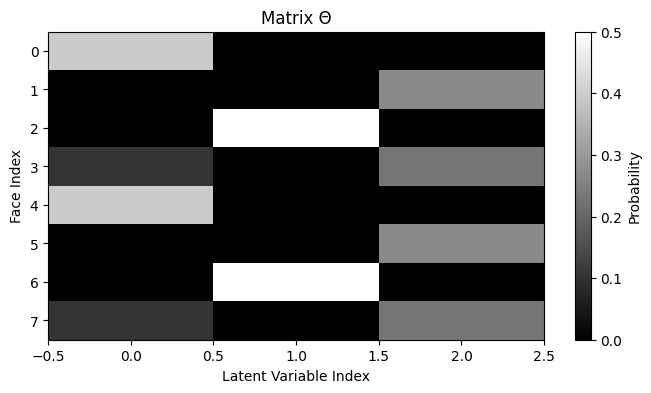

In [75]:
# PLot Theta
plt.figure(figsize=(8, 4))
plt.imshow(Theta, aspect='auto', cmap='gray')
plt.colorbar(label='Probability')
plt.title('Matrix Θ')
plt.xlabel('Latent Variable Index')
plt.ylabel('Face Index')
plt.show()

# **P3: PLSI for Analyzing X (Twitter) Data Stream**

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa as lb
import scipy.io
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Audio

In [ ]:
src_dir = "/content/drive/MyDrive/Colab drive"

In [ ]:
twt= scipy.io.loadmat(os.path.join(src_dir, 'x_formerly_known_as_twitter.mat'))
Xtr = twt['Xtr']
Xte = twt['Xte']
YtrMat = twt['YtrMat']
YteMat = twt['YteMat']

The .mat file required for this question has been successfully uploaded into the colab and required rows and columns have been extracted from it.

In [ ]:
plsi_topics = np.random.randn(891, 50)
plsi_weights = np.random.randn(50, 773)

In [ ]:
for i in range(500):

    den = np.dot(plsi_topics,plsi_weights)
    den[den == 0] = 0.0001

    plsi_topics = plsi_topics * np.dot((Xtr/den), plsi_weights.T)
    plsi_topics = plsi_topics / np.dot(np.ones([plsi_topics.shape[0], plsi_topics.shape[0]]), plsi_topics)

    den = np.dot(plsi_topics,plsi_weights)
    den[den == 0] = 0.0001

    plsi_weights = plsi_weights * np.dot(plsi_topics.T, (Xtr/den))
    plsi_weights = plsi_weights / np.dot(np.ones([plsi_weights.shape[0], plsi_weights.shape[0]]), plsi_weights)

In [ ]:
plsi_weights2 = np.random.rand(50,193)

for i in range(500):

    den = np.dot(plsi_topics, plsi_weights2)
    den[den == 0] = 0.0001

    plsi_weights2 = plsi_weights2 * np.dot(plsi_topics.T, (Xte/den))
    plsi_weights2 = plsi_weights2 / np.dot(np.ones([plsi_weights2.shape[0], plsi_weights2.shape[0]]), plsi_weights2)

In [ ]:
alpha = 0.005

W = np.random.uniform(0, 5, (3, plsi_weights.shape[0]))
b = np.random.uniform(0, 5, (3,1))
error_plot = []

for i in range(1000):

    Y_hat = np.exp(np.dot(W, plsi_weights) + b)
    Y_hat = Y_hat / np.sum(Y_hat, axis=0).reshape(1,-1)

    error = -np.sum(YtrMat * np.log(Y_hat))

    delta_w = np.dot((Y_hat - YtrMat), plsi_weights.T)
    delta_b = np.dot((Y_hat - YtrMat), np.ones([YtrMat.shape[1],1]))

    W = W - (alpha * delta_w)
    b = b - (alpha * delta_b)

    error_plot.append(error)

In [ ]:
Z = np.dot(W, plsi_weights2) + b
Y_hat_test = np.exp(Z)

Y_hat_test = Y_hat_test / np.sum(Y_hat_test, axis=0).reshape(1,-1)

train_accuracy = np.sum(np.argmax(Y_hat, axis=0) == np.argmax(YtrMat, axis=0)) / YtrMat.shape[1]
test_accuracy = np.sum(np.argmax(Y_hat_test, axis=0) == np.argmax(YteMat, axis=0)) / YteMat.shape[1]

In [ ]:
print('Training accuacy is: ' + str(np.round(train_accuracy, 4)))
print('Testing accuacy is: ' + str(np.round(test_accuracy, 4)))

Training accuacy is: 0.6675
Testing accuacy is: 0.5855


Above are the resulted trainig and testing classification accuracies

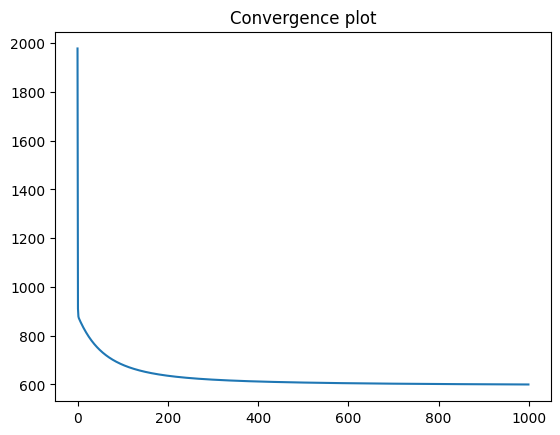

In [ ]:
plt.title('Convergence plot')
plt.plot(error_plot)
plt.show()

The above plot is a convergence graph from the calculation. This plot demonstrates the reduction of error and it getting converged eventually.

# **P4: Rock or Metal**

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt

In [ ]:
src_dir = "/content/drive/MyDrive/Colab drive"

In [ ]:
trxmat= scipy.io.loadmat(os.path.join(src_dir, 'trX.mat'))
trxmat= trxmat['trX']
trymat = scipy.io.loadmat(os.path.join(src_dir, 'trY.mat'))
trymat= trymat['trY']

trX and try matrices have been uploaded into colab and successfully selected only the required columns for the question

In [ ]:
trxmat.shape

(2, 160)

In [ ]:
trymat.shape

(1, 160)

In [ ]:
def AdaBoost(learn_count, itermax, alpha, trxmat, trymat):

    fx = 0
    learnw = np.ones((1,trxmat.shape[1]))
    geterror, learnw_list, blist = list(), list(), list()

    for m in range(learn_count):

        W, b = np.random.uniform(-2, 2, (1, 2)), np.random.uniform()

        iter = 0

        while iter <= itermax:

            Z = np.dot(W, trxmat) + b
            pred = np.tanh(Z)

            backprop_error = -learnw * (trymat - pred) * (1 - pred**2)
            delta_w = np.dot(backprop_error, trxmat.T)
            delta_b = np.dot(backprop_error, np.ones_like(trymat).T)

            W = W - (alpha * delta_w)
            b = b - (alpha * delta_b)

            iter += 1

        beta = 0.5 * np.log(np.sum(learnw * (np.sign(pred) == trymat)) / np.sum(learnw * (np.sign(pred) != trymat)))
        fx = fx + beta * np.sign(pred)
        error = np.sum(np.sign(fx) != trymat)
        learnw = learnw * np.exp(- beta * trymat * np.sign(pred))

        geterror.append(error)
        learnw_list.append(learnw)

    return fx, geterror

Using the equation provided in the question, the above algorithm defines the AdaBoost training algorithm efficiently.  

In [ ]:
fx, geterror = AdaBoost(1000, 1000, 0.05, trxmat, trymat)

print("The resulted training accuracy by using 1000 weak learners is: " + str(np.sum(np.sign(fx) == trymat) / trymat.shape[1]))

The resulted training accuracy by using 1000 weak learners is: 0.83125


After the training 1000 weak learner for 1000 iterations the resulted accuracy of the training is 0.83125 (around 84 percent)

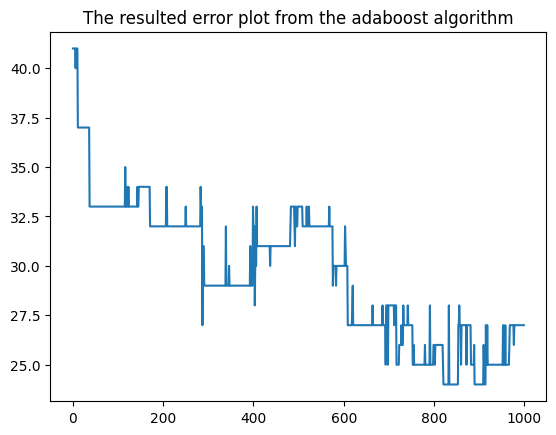

In [ ]:
plt.title('The resulted error plot from the adaboost algorithm')
plt.plot(geterror)
plt.show()

The above plot depicts the resulted error from the AdaBoost algorithm. From this plot we can infer that resulted error has been reduced gradually and in the 1000th iteration the error reduction almost became stable which defines the algorithm has been implemented successfully and efficiently